In [1]:
import pandas as pd

In [2]:
dtype = {'tweet_id': str,
         'user_id': str,
         'retweeted_user_id': str,
         'retweeted_status_id': str}

retweets_df = pd.read_csv("data/preprocessed_tweets_dataset.csv", parse_dates=[1], dtype=dtype)

In [3]:
retweets_df

,tweet_id,created_at,user_id,retweeted_user_id,retweeted_status_id,retweet_count,likes_count,retweeted_text,root_domains,newsguard_rating
0,1340468299025551360,2020-12-20 01:25:21+00:00,497188910,1017807360075665408,1340325850378592257,4,0,@GagliardoneS @amnesia96225614 https://t.co/L3...,affaritaliani.it,64.5
1,1340468728534884354,2020-12-20 01:27:04+00:00,924336025387913221,NaN,NaN,0,0,NaN,lastampa.it,95.0
2,1340473042129080320,2020-12-20 01:44:12+00:00,47148805,NaN,NaN,0,0,NaN,nytimes.com,100.0
3,1340474125656190978,2020-12-20 01:48:31+00:00,1022891525242593280,NaN,NaN,1,3,NaN,imolaoggi.it,5.0
4,1340477947627581440,2020-12-20 02:03:42+00:00,908206586,NaN,NaN,0,0,NaN,repubblica.it tweetedtimes.com,95.0
...,...,...,...,...,...,...,...,...,...,...
827225,1451536212381011970,2021-10-22 13:09:35+00:00,1329549977463508993,4758512368,1450461737895989261,0,0,"Australia, Djokovic contro i media: “È terrifi...",stopcensura.online,39.5
827226,1451536215858155528,2021-10-22 13:09:36+00:00,1446561632105205774,1446561632105205774,1451536139131801605,0,0,SE DICCESSE 14 MILIONI DI NON VACCINATI IL GOV...,tgcom24.mediaset.it,82.5
827227,1451536226876526601,2021-10-22 13:09:39+00:00,712365073,1173682089637625856,1451310094461947909,0,0,"Pericardite dopo il vaccino, testimonianza del...",lapekoranera.it,12.5
827228,1451536327388942348,2021-10-22 13:10:03+00:00,1036611673,1260895357548068865,1451536158098399236,0,0,"I vaccinati per forza non la prenderanno bene,...",maurizioblondet.it,20.0


In [4]:
retweets_df[['tweet_id', 'created_at', 'user_id', 'retweeted_user_id',
             'retweeted_status_id', 'retweeted_text', 'root_domains', 'newsguard_rating']].sample(3)

,tweet_id,created_at,user_id,retweeted_user_id,retweeted_status_id,retweeted_text,root_domains,newsguard_rating
457280,1400211672321646592,2021-06-02 22:04:12+00:00,317671787,NaN,NaN,NaN,informazione.it,70.0
674102,1430867682916814848,2021-08-26 12:20:14+00:00,1349303685243932672,NaN,NaN,NaN,visionetv.it,12.5
174549,1367434991177711616,2021-03-04 11:21:22+00:00,3025325920,NaN,NaN,NaN,infodifesa.it,70.0


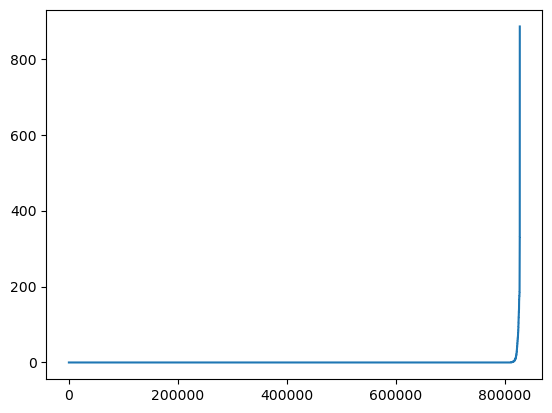

In [5]:
# Retweets count is not reliable... to be inferred at period end
retweets_df["retweet_count"].sort_values().reset_index(drop=True).plot.line();

In [6]:
newsguard_map_df = pd.read_csv("newsguard_map.csv", index_col=0)
newsguard_map_df

,score
identifier,
100giornidaleoni.it,30.0
10news.com,100.0
11alive.com,100.0
13wham.com,90.0
14news.com,100.0
...,...
zdf.de,100.0
zdnet.com,100.0
zeit.de,92.5


In [7]:
# Root domain frequency
rdom = []
for x in retweets_df["root_domains"]:
    for y in x.split(' \n'):
        try:
            ng_score = newsguard_map_df.loc[y][0]
            rdom.append((y, ng_score))
        except KeyError:
            continue


scored = pd.DataFrame(rdom, columns=["root_domain", "score"])  #.value_counts().head(30).plot(kind='barh', figsize=(10, 6));
scored['reliable'] = ["green" if is_reliable else "red" for is_reliable in scored['score'] >= 75]
scored = pd.DataFrame(scored.value_counts()).reset_index()

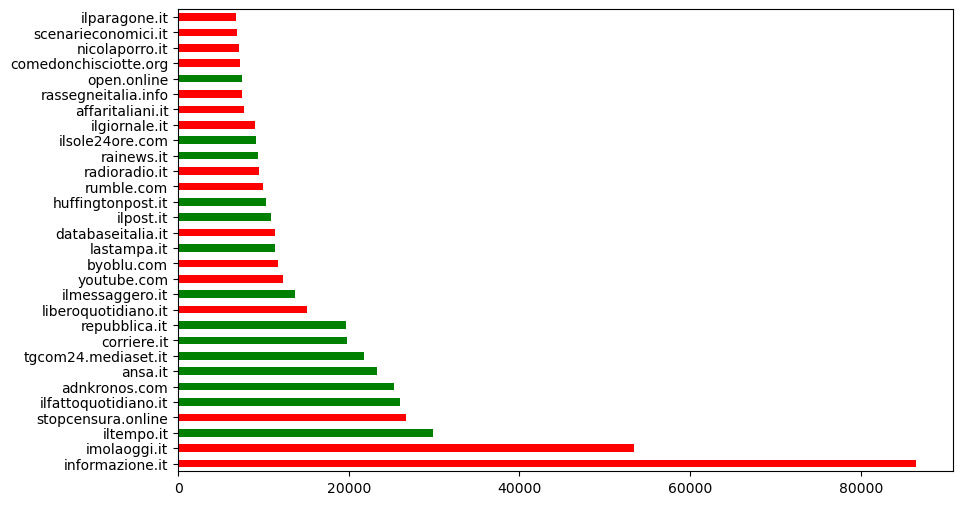

In [8]:
scored.head(30).plot(x="root_domain", y="count",
                     kind="barh",
                     color=scored["reliable"],
                     figsize=(10, 6),
                     legend=False,
                     ylabel='');

In [9]:
print(f"Newsguard used ratings: {round(len(scored) * 100 / len(newsguard_map_df), 2)}%")

Newsguard used ratings: 84.63%


## Split the data (observation and evaluation periods)

In [10]:
# Make sure data is sorted in chronological order
retweets_df = retweets_df.sort_values(by="created_at")

In [11]:
retweets_df

,tweet_id,created_at,user_id,retweeted_user_id,retweeted_status_id,retweet_count,likes_count,retweeted_text,root_domains,newsguard_rating
0,1340468299025551360,2020-12-20 01:25:21+00:00,497188910,1017807360075665408,1340325850378592257,4,0,@GagliardoneS @amnesia96225614 https://t.co/L3...,affaritaliani.it,64.5
1,1340468728534884354,2020-12-20 01:27:04+00:00,924336025387913221,NaN,NaN,0,0,NaN,lastampa.it,95.0
2,1340473042129080320,2020-12-20 01:44:12+00:00,47148805,NaN,NaN,0,0,NaN,nytimes.com,100.0
3,1340474125656190978,2020-12-20 01:48:31+00:00,1022891525242593280,NaN,NaN,1,3,NaN,imolaoggi.it,5.0
4,1340477947627581440,2020-12-20 02:03:42+00:00,908206586,NaN,NaN,0,0,NaN,repubblica.it tweetedtimes.com,95.0
...,...,...,...,...,...,...,...,...,...,...
827225,1451536212381011970,2021-10-22 13:09:35+00:00,1329549977463508993,4758512368,1450461737895989261,0,0,"Australia, Djokovic contro i media: “È terrifi...",stopcensura.online,39.5
827226,1451536215858155528,2021-10-22 13:09:36+00:00,1446561632105205774,1446561632105205774,1451536139131801605,0,0,SE DICCESSE 14 MILIONI DI NON VACCINATI IL GOV...,tgcom24.mediaset.it,82.5
827227,1451536226876526601,2021-10-22 13:09:39+00:00,712365073,1173682089637625856,1451310094461947909,0,0,"Pericardite dopo il vaccino, testimonianza del...",lapekoranera.it,12.5
827228,1451536327388942348,2021-10-22 13:10:03+00:00,1036611673,1260895357548068865,1451536158098399236,0,0,"I vaccinati per forza non la prenderanno bene,...",maurizioblondet.it,20.0


### Account activity: Tweets per day

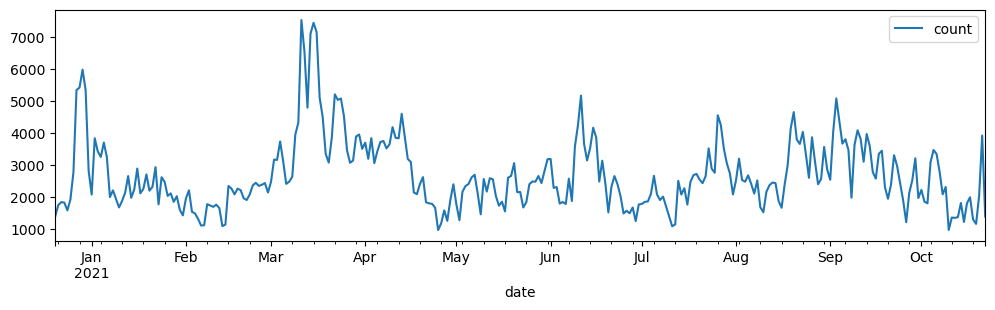

In [12]:
retweets_per_day_df = retweets_df.copy()

retweets_per_day_df["date"] = (retweets_per_day_df["created_at"].dt.day.astype(str) + "." +
                               retweets_per_day_df["created_at"].dt.month.astype(str) + "." +
                               retweets_per_day_df["created_at"].dt.year.astype(str))

retweets_per_day_df["count"] = 1

retweets_per_day_df = retweets_per_day_df[["date", "count"]].groupby("date").agg("sum")

retweets_per_day_df = retweets_per_day_df.reset_index()

retweets_per_day_df["date"] = pd.to_datetime(retweets_per_day_df["date"], format="%d.%m.%Y")

retweets_per_day_df = retweets_per_day_df.sort_values(by="date").reset_index(drop=True)

retweets_per_day_df.plot.line("date", "count", figsize=(12,3));

In [13]:
print(len(retweets_per_day_df),
      "days in total, from",
      retweets_per_day_df.iloc[0]["date"].strftime('%d/%m/%Y'),
      "to",
      retweets_per_day_df.iloc[-1]["date"].strftime('%d/%m/%Y'))

307 days in total, from 20/12/2020 to 22/10/2021


In [14]:
# Top 3 retweet traffic days
retweets_per_day_df.sort_values(by="count", ascending=False).head(3)

,date,count
81,2021-03-11,7514
85,2021-03-15,7428
86,2021-03-16,7141


In [15]:
# Bottom 3 retweet traffic days
retweets_per_day_df.sort_values(by="count", ascending=False).tail(3)

,date,count
203,2021-07-11,1092
294,2021-10-10,979
126,2021-04-25,976


In [16]:
# Total nodes (accounts)
print("Total accounts:", pd.concat([retweets_df.user_id, retweets_df.retweeted_user_id]).nunique())

Total accounts: 75060


Since in the paper: https://arxiv.org/pdf/2207.09524.pdf they use one month as observation period this is the suggested split:
- Observation period: 20/12/2020 - 28/2/2021
- Evaluation period: 1/3/2021 - 22/10/2021

In [17]:
# Splitting data by periods
split_date = "2021-03-01"
observation_df = retweets_df[retweets_df["created_at"] <= split_date]
evaluation_df = retweets_df[retweets_df["created_at"] > split_date]

In [18]:
# Split size test
print("Last observed tweet:", observation_df.created_at.iloc[-1])
print("First evaluated tweet:", evaluation_df.created_at.iloc[0])
print("Sum of tweets equal to all retweets:", len(observation_df) + len(evaluation_df) == len(retweets_df))

Last observed tweet: 2021-02-28 23:55:43+00:00
First evaluated tweet: 2021-03-01 00:00:46+00:00
Sum of tweets equal to all retweets: True


In [19]:
# Observation period total nodes
print("Observation accounts:", pd.concat([observation_df.user_id, observation_df.retweeted_user_id]).nunique())

Observation accounts: 29974


In [20]:
# Evaluation period total nodes
print("Evaluation accounts:", pd.concat([evaluation_df.user_id, evaluation_df.retweeted_user_id]).nunique())

Evaluation accounts: 62729


They're far less than the paper but this is a COVID topic specific dataset.

In [21]:
# Saving the splits
observation_df.to_csv("data/observation_retweets.csv", index=False)
evaluation_df.to_csv("data/evaluation_retweets.csv", index=False)